In [1]:
from datasets import load_dataset

/Users/shilongcui/shilongjaycui/mental-health-insights/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset('emotion')

/Users/shilongcui/shilongjaycui/mental-health-insights/venv/lib/python3.11/site-packages/datasets/load.py:1429: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [3]:
import pandas as pd

pd.set_option('display.max_colwidth', None)  # Show full column width

In [4]:
from pandas import DataFrame

train_dataset = dataset['train']
train_df: DataFrame = dataset["train"].to_pandas()
train_df.sample(n=5)

,text,label
13355,i will be able to let that passion out but at present these little paintings help me feel reassured not to let my dreams or creativity die a href https lh,1
11314,i feel like i am not special,1
8553,i have been feeling is any indication on this childs personality then i am petrified,4
4324,i feel is hostile kinship or mounting nausea did you know that back means the binding itself,3
3218,im feeling groggy and horrid,0


In [5]:
from typing import Dict

emotion_dict: Dict[int, str] = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise',
}

train_df_copy = train_df.copy(deep=True)
train_df_copy['emotion'] = train_df_copy['label'].apply(lambda index: emotion_dict[index])
train_df_copy = train_df_copy[['text', 'emotion']]
train_df_copy

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplace i will know that it is still on the property,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag and i said to anna that i feel like i have been beaten up,sadness
15996,i am now turning and i feel pathetic that i am still waiting tables and subbing with a teaching degree,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and im glad that t,anger


In [6]:
from pandas import Series
X: Series = train_df['text']
y: Series = train_df['label']

print(f'X.shape: {X.shape}')
print(f'X: {X.tolist()[:5]}')

print(f'\ny.shape: {y.shape}')
print(f'y: {y.tolist()[:5]}')

X.shape: (16000,)
X: ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']

y.shape: (16000,)
y: [0, 0, 3, 2, 3]


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

In [8]:
# Creating the pipeline
model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier())
])

In [9]:
model.fit(X, y)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', RandomForestClassifier())])

In [37]:
from sklearn.metrics import accuracy_score, classification_report
from typing import List

print(dataset.column_names)

# For a classification task
X_test: List = dataset['test']['text']
y_test: List = dataset['test']['label']

y_pred = model.predict(X=X_test)  # predict the actual class
print("Accuracy:", accuracy_score(y_true=y_test, y_pred=y_pred))
print(classification_report(y_test, y_pred))

{'train': ['text', 'label'], 'validation': ['text', 'label'], 'test': ['text', 'label']}
Accuracy: 0.866
              precision    recall  f1-score   support

           0       0.93      0.90      0.92       581
           1       0.84      0.94      0.88       695
           2       0.82      0.62      0.70       159
           3       0.90      0.83      0.86       275
           4       0.85      0.85      0.85       224
           5       0.68      0.58      0.62        66

    accuracy                           0.87      2000
   macro avg       0.83      0.79      0.81      2000
weighted avg       0.87      0.87      0.86      2000



Create a precision-recall curve.

In [24]:
# Get predicted probabilities for the positive class
y_scores = model.predict_proba(X=X_test)  # predict the class probabilities
print(f'y_scores: {y_scores}')
print(f'y_scores.shape: {y_scores.shape}')

y_scores: [[0.52 0.19 0.02 0.15 0.11 0.01]
 [0.83 0.11 0.   0.01 0.05 0.  ]
 [0.79 0.13 0.01 0.05 0.02 0.  ]
 ...
 [0.11 0.77 0.06 0.04 0.02 0.  ]
 [0.16 0.69 0.01 0.07 0.07 0.  ]
 [0.11 0.19 0.01 0.03 0.43 0.23]]
y_scores.shape: (2000, 6)


In [25]:
from sklearn.metrics import precision_recall_curve

# Compute precision-recall curve values
try:
    precision, recall, _ = precision_recall_curve(y_true=y_test, probas_pred=y_scores)
except ValueError:
    print('`precision_recall_curve` is designed for binary classification problems.')
    print('''ChatGPT: While precision-recall curves are commonly associated with binary
          classification problems, they can be extended to multi-class scenarios by
          considering each class as a separate binary classification problem.''')

`precision_recall_curve` is designed for binary classification problems.
ChatGPT: While precision-recall curves are commonly associated with binary
          classification problems, they can be extended to multi-class scenarios by
          considering each class as a separate binary classification problem.


In [31]:
from sklearn.metrics import auc
from numpy import ndarray
import numpy as np

# Compute precision-recall curves for each class
precision_dict: Dict = {}
recall_dict: Dict = {}
average_precision: Dict = {}

# Loop through each class
for i in range(len(model.classes_)):
    # Compute precision-recall curve
    y_test: ndarray = np.array(y_test)
    precision_dict[i], recall_dict[i], _ = precision_recall_curve(y_test == i, y_scores[:, i])

    # Compute area under the curve (AUC) for precision-recall curve
    average_precision[i] = auc(recall_dict[i], precision_dict[i])

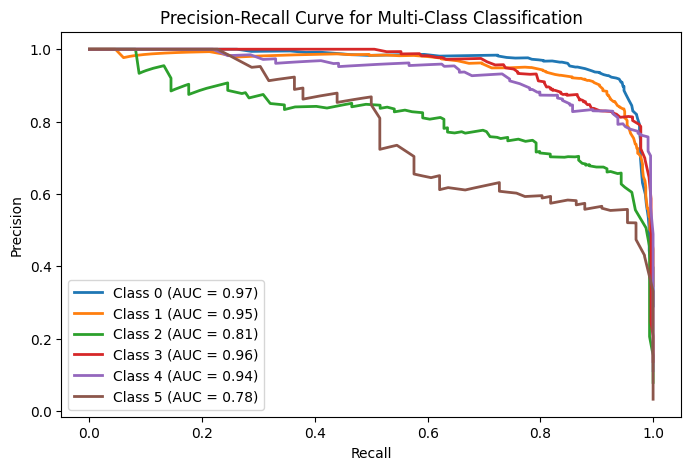

In [36]:
import matplotlib.pyplot as plt

# Plot the precision-recall curves for each class
plt.figure(figsize=(8, 5))
for i in range(len(model.classes_)):
    plt.plot(
        recall_dict[i],
        precision_dict[i],
        lw=2,
        label=f'Class {i} (AUC = {average_precision[i]:.2f})',
    )

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multi-Class Classification')
plt.legend(loc='best')
plt.show()

Create a confusion matrix.

In [38]:
from sklearn.metrics import confusion_matrix

conf_matrix: ndarray = confusion_matrix(y_true=y_test, y_pred=y_pred)

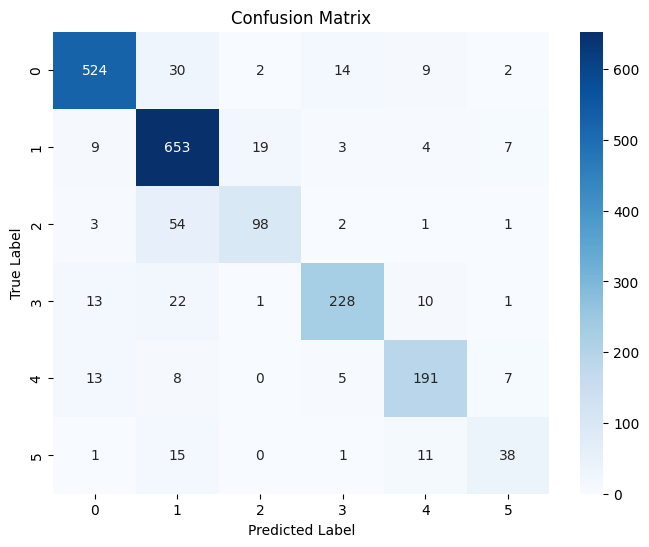

In [39]:
import seaborn as sns

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=model.classes_,
            yticklabels=model.classes_,
)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()